# Hopfield Network

In [1]:
# imports

import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from hopfield_experiments import utils
from hopfield_experiments import hopfield
from tqdm import tqdm
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio
import mplcyberpunk

plt.style.use("cyberpunk")
import gc

seed = 42
np.random.seed(seed)

In [2]:
# setting font size for graphs

SIZE = 14

plt.rc('font', size=SIZE)
plt.rc('axes', titlesize=SIZE)  
plt.rc('axes', labelsize=SIZE)  
plt.rc('xtick', labelsize=SIZE)    
plt.rc('ytick', labelsize=SIZE)  
plt.rc('legend', fontsize=SIZE) 
plt.rc('figure', titlesize=SIZE)

# set color cycle

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

In [3]:
# load mnist data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_data = {i:None for i in range(10)}

for i in range(10):
    xi = X_test[y_test==i]
    train_data[i] = xi

## Demo

In [4]:
# get some digits & preprocess

demo_train = []
digits = np.random.randint(0, 10, size=3)

for i in digits:
    demo_train.append(X_train[y_train==i][0])

demo_train = [utils.preprocessing(i) for i in demo_train]

In [15]:
# train model & test with 20% corruption

model = hopfield.HopfieldNetwork()
model.train(demo_train)

demo_test = [utils.get_corrupted_input(x, 0.2) for x in demo_train]
preds = model.predict(demo_test, threshold=100, num_iter=20)

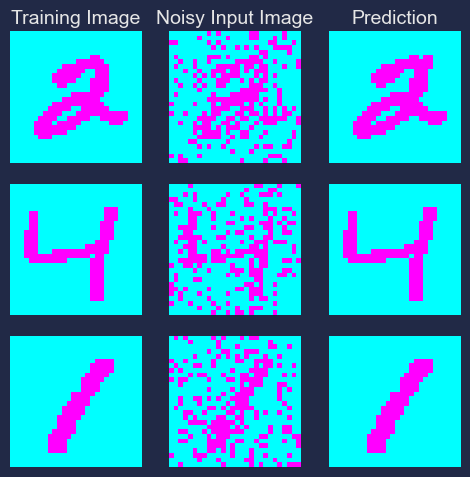

In [16]:
# plot demo samples

utils.plot(demo_train, demo_test, preds)

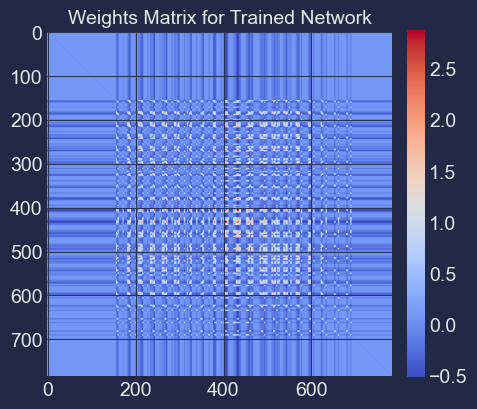

In [17]:
# plot weight matrix

model.plot_weight_matrix()

In [18]:
gc.collect()

22754

## Evaluation

In [5]:
# define metric dicts and corruption levels (10 to 50%)

mse = {i:[] for i in range(10)}
psnr = {i:[] for i in range(10)}
ssim = {i:[] for i in range(10)}

corruption_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

In [6]:
# train network and evaluate metrics for digits

for i in tqdm(range(10)):

    train = train_data[i]
    # preprocess data
    train_processed = [utils.preprocessing(x) for x in train]

    # instantiate model & train
    model = hopfield.HopfieldNetwork()
    model.train(train_processed)

    # pattern recovery for varying corruption levels
    for corruption in corruption_levels:
        test = [utils.get_corrupted_input(x, corruption) for x in train_processed]
        preds = model.predict(test, threshold=70, num_iter=30)
        total_mse = 0
        total_psnr = 0
        total_ssim = 0
        for j in range(len(train)):
            total_mse += mean_squared_error(train_processed[j], preds[j])
            total_psnr += peak_signal_noise_ratio(train_processed[j], preds[j].astype('int32'), data_range=255)
            total_ssim += structural_similarity(train_processed[j], preds[j].astype('int32'), data_range=255)
        mse[i].append(total_mse/len(test))
        psnr[i].append(total_psnr/len(test))
        ssim[i].append(total_ssim/len(test))
        

100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


In [7]:
gc.collect()

104

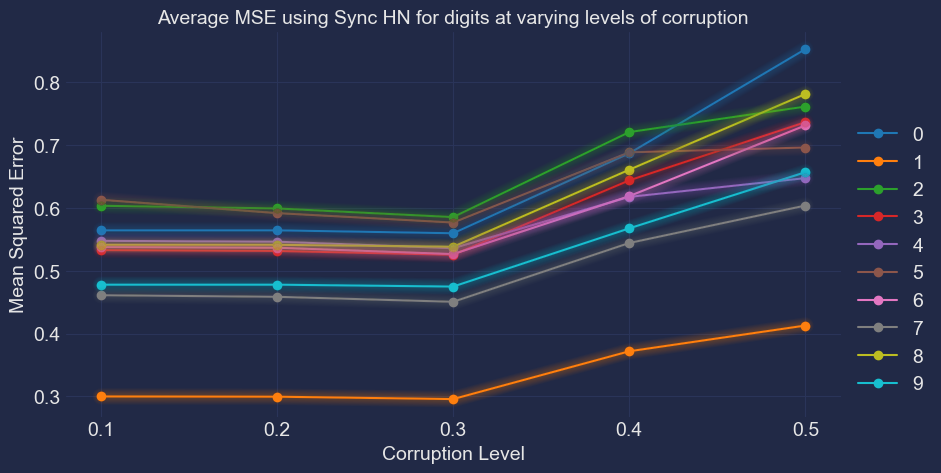

In [9]:
# plot mse

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, mse[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Mean Squared Error")
plt.title("Average MSE using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

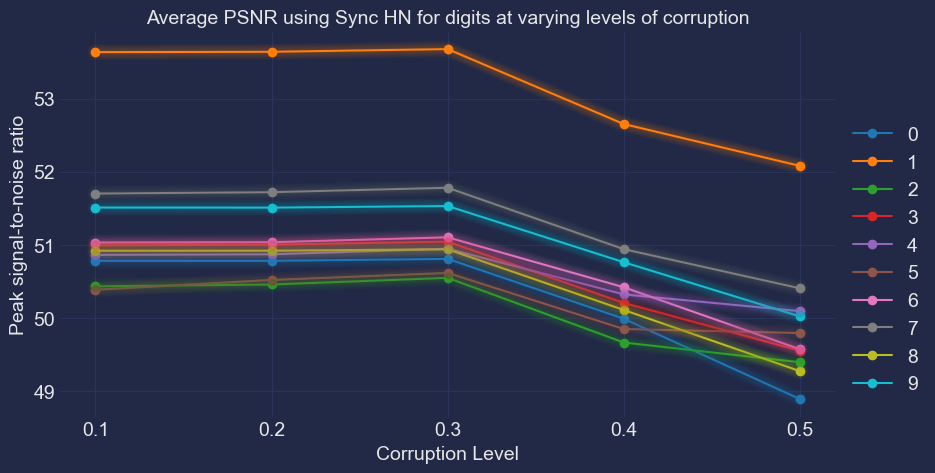

In [10]:
# plot psnr

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, psnr[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Peak signal-to-noise ratio")
plt.title("Average PSNR using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

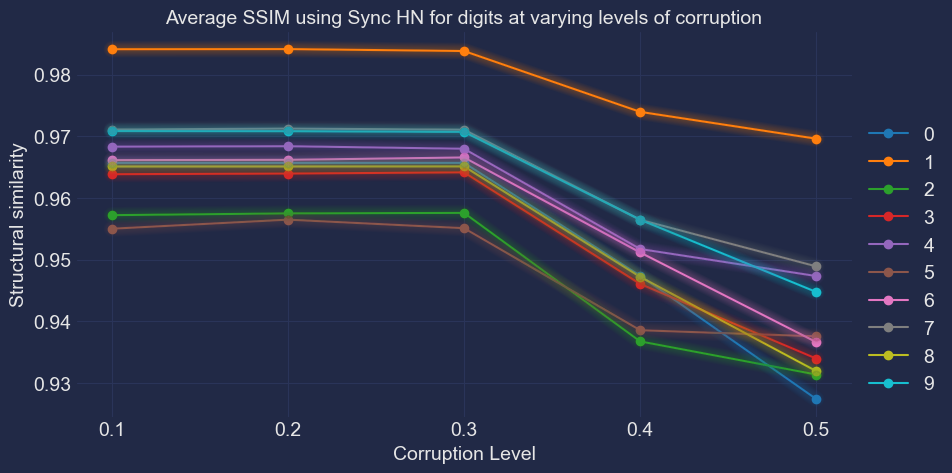

In [11]:
# plot ssim

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, ssim[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Structural similarity")
plt.title("Average SSIM using Sync HN for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

In [12]:
gc.collect()

25613